In [1]:
import scipy.io
import scipy as sp
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad 
from autograd import hessian
from autograd import jacobian
from autograd.misc.flatten import flatten_func
from autograd import value_and_grad 
from matplotlib import gridspec
%matplotlib inline

In [2]:
# gradient descent function 
def conj_gradient_descent(g,alpha,beta,norm,steprule,max_its,w0):
    
    tol = 1e-10
    exitflag = 0

    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w0] # weight history container
    cost_history = [g(w0)] # cost function history container
    #dtemp = gradient(w0)
    dtemp = 0;
    k = 1
    while k <= max_its and exitflag == 0:
        # evaluate the gradient
        grad_eval = gradient(w0)

        # take (momentum-accelerated) gradient descent step
        if norm == 'component':
            d = (1-beta)*dtemp + beta*np.sign(grad_eval)*np.sqrt(len(w0))
        elif norm == 'full':
            grad_eval = grad_eval/np.linalg.norm(grad_eval)
            d = (1-beta)*dtemp + beta*grad_eval
        else:
            d = (1-beta)*dtemp + beta*grad_eval
            
        wtemp = w0;   
        w0 = w0 - alpha*d
        
        if steprule == 'backtrack':
            t = 0.8
            #alpha = 1
            h = g(wtemp)+gradient(wtemp).T@(w0-wtemp)+1/(2*alpha)*np.linalg.norm(w0-wtemp)**2
            while g(w0) > h:
                alpha = t*alpha
                w0 = w0 - alpha*d
                h = g(wtemp)+gradient(wtemp).T@(w0-wtemp)+1/(2*alpha)*np.linalg.norm(w0-wtemp)**2
                wtemp = w0
            w0 = w0 - alpha*d
        elif steprule == 'diminishing':
            alpha = 1/k
        else:
            alpha = alpha
            
        if np.linalg.norm(w0-weight_history[-1]) < tol:
            exitflag = 1
        k += 1
        
        # record weight and cost
        weight_history.append(w0)
        cost_history.append(g(w0))
        dtemp = d
        
    return weight_history,cost_history,exitflag

In [3]:
# def distmat(u,v):
#     # needs column vectors
#     from scipy.spatial import distance_matrix 
#     D1 = distance_matrix(u,v)
#     return D1

def distmat_v2(u,v):
    from scipy.spatial import distance_matrix 
    Daa = []
    for i in range(u.shape[1]):
        Daa.append(distance_matrix(u[:,i][:,np.newaxis],v[:,i][:,np.newaxis]))
    return Daa
    

# def kernfcn(X,Y,theta):
#     D = np.zeros((X.shape[0],Y.shape[0]))
#     Daa = []
#     for i in range(X.shape[1]):
#         Da = distmat(X[:,i][:,np.newaxis],Y[:,i][:,np.newaxis])
#         Da = Da**2
#         D += Da/theta[i]**2
#         Daa.append(Da)
#     K = np.exp(-1/2*D)
#     return K,Daa

def kernfcn_v2(Daa,theta):
    D = np.zeros((Daa[0].shape[0],Daa[0].shape[1]))
    for i in range(len(Daa)):
        D += Daa[i]**2/theta[i]**2
    K = np.exp(-1/2*D)
    return K
        

def gprfcn(xTest,xTrain,yTrain,theta,sigmaY):
#     K,_ = kernfcn(xTrain,xTrain,theta)
#     Ks,_ = kernfcn(xTest,xTrain,theta)
#     Kss,_ = kernfcn(xTest,xTest,theta)
    Daa1 = distmat_v2(xTrain,xTrain)
    Daa2 = distmat_v2(xTest,xTrain)
    Daa3 = distmat_v2(xTest,xTest)
    K = kernfcn_v2(Daa1,theta)
    Ks = kernfcn_v2(Daa2,theta)
    Kss = kernfcn_v2(Daa3,theta)
    
    if sigmaY == 0:
        eps = 1e-15*K.shape[0]*np.eye(K.shape[0])
    else:
        eps = sigmaY**2*np.eye(K.shape[0])
    L = np.linalg.cholesky(K+eps)
    alpha = np.linalg.solve(L.T,np.linalg.solve(L,yTrain))
    theta1 = 1/K.shape[0]*np.dot(yTrain.T,alpha)
    
    K = theta1*K; Ks = theta1*Ks; Kss = theta1*Kss;
    L = np.linalg.cholesky(K+eps)
    alpha = alpha/theta1
    Mu = np.dot(Ks,alpha)
    v = np.linalg.solve(L,Ks.T)
    Cov = Kss - np.dot(v.T,v); Cov[Cov<1e-60] = 0;
    return Mu,Cov,K,Ks,Kss,L,alpha,v

def mlefcn(xTrain,yTrain,Daa,theta,sigmaY):
    #K,_ = kernfcn(xTrain,xTrain,theta)
    K = kernfcn_v2(Daa,theta)
    if sigmaY == 0:
        eps = 1e-15*K.shape[0]*np.eye(K.shape[0])
    else:
        eps = sigmaY**2*np.eye(K.shape[0])
    L = np.linalg.cholesky(K+eps)
    alpha = np.linalg.solve(L.T,np.linalg.solve(L,yTrain))
    theta1 = 1/K.shape[0]*np.dot(yTrain.T,alpha)
    logL = -K.shape[0]/2*(np.log(2*np.pi)+1) - K.shape[0]/2*np.log(theta1) - np.sum(np.log(np.diag(L)))
    return -logL

def hypopt(nruns,max_its,alpha,beta,normrule,steprule,xTrain,yTrain,Daa,sigmaY):
    mle = lambda x: mlefcn(xTrain,yTrain,Daa,x,sigmaY)
    param_cont = []
    cost_cont = []
    flag_cont = []
    for n in range(nruns):
        x0 = np.random.rand(xTrain.shape[1])
        w1,g1,exitflag = conj_gradient_descent(mle,alpha,beta,normrule,steprule,max_its,x0)
        param_cont.append(w1)
        cost_cont.append(g1)
        flag_cont.append(exitflag)
    return param_cont, cost_cont, flag_cont

def hypopt_wrap(nruns,max_its,alpha,beta,normrule,steprule,xTrain,yTrain,Daa,sigmaY):
    param_cont, cost_cont, flag_cont = hypopt(nruns,max_its,alpha,beta,normrule,steprule,xTrain,yTrain,Daa,sigmaY)
    ff = np.zeros(nruns)
    for i in range(nruns):
        ff[i] = cost_cont[i][-1]
    iopt = np.argmin(ff)
    return param_cont[iopt][-1]

def expected_improvement(Mu,Cov,kappa):
    Mu = np.squeeze(Mu)
    from scipy.stats import norm
    sigma = np.sqrt(np.diag(Cov))
    with np.errstate(divide='warn'):
        imp = Mu - np.max(Mu) - kappa
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

def plot1Dgpr(x,y,xT,yT,s,Mu,Cov,EI):
    fig = plt.figure(figsize = (10,8))
    plt.rcParams.update({'font.size': 20})
    gs = gridspec.GridSpec(2,1,hspace=0.4) 
    ax1 = plt.subplot(gs[0]); 
    ax2 = plt.subplot(gs[1])

    ax1.scatter(xT,yT)
    ax1.plot(s,Mu)
    ax1.fill_between(np.squeeze(s), np.squeeze(Mu)-2*np.sqrt(np.diag(Cov)), np.squeeze(Mu)+2*np.sqrt(np.diag(Cov)), color="#348ABD", alpha=0.25, label='2 sigma')
    ax1.plot(x,y,linewidth=2,color=[1,0,0])
    ax1.set_xlabel('x',Fontsize=16)
    ax1.set_ylabel('y(x)',Fontsize=16)
    ax1.grid(True)

    ax2.fill_between(np.squeeze(s), np.zeros(len(s)), ei, color=[0,0.7,0], alpha=0.25)
    ax2.set_xlabel('x',Fontsize=16)
    ax2.set_ylabel('EI(x)',Fontsize=16)
    ax2.grid(True)
    
    plt.show()

### 1D Synthetic Data####

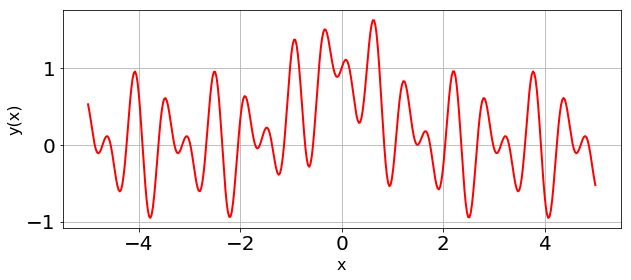

In [280]:
sigmaY = 0
flag_plot = 1

P = 400
x = np.linspace(-5,5,P)[:,np.newaxis]
y = np.exp(-x**2)+np.sin(2*x)*np.cos(10*x)
imax = np.argmax(y)
ymax = y[imax]; xmax = x[imax,:];


fig = plt.figure(figsize = (10,4))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(1,1) 
ax1 = plt.subplot(gs[0]); 
ax1.plot(x,y,linewidth=2,color=[1,0,0])
ax1.set_xlabel('x',Fontsize=16)
ax1.set_ylabel('y(x)',Fontsize=16)
ax1.grid(True)

In [277]:
nruns = 10
max_its = 1e3
alpha = 0.01
beta = 1
normrule = 'component'
steprule = 'normal'
#theta_hist,fval,flag = hypopt(nruns,max_its,alpha,beta,normrule,steprule,xT,yT,sigmaY)
theta = hypopt_wrap(nruns,max_its,alpha,beta,normrule,steprule,xT,yT,sigmaY)

In [289]:
Mu,Cov,K,Ks,Kss,L,alpha,v = gprfcn(x,xT,yT,theta,sigmaY)
ei = expected_improvement(Mu,Cov,0.01)

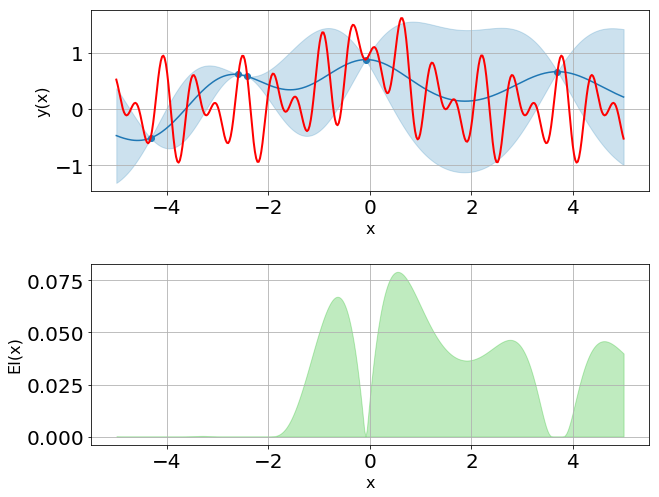

In [299]:
fig = plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(2,1,hspace=0.4) 
ax1 = plt.subplot(gs[0]); 
ax2 = plt.subplot(gs[1])

ax1.scatter(xT,yT)
ax1.plot(x,Mu)
ax1.fill_between(np.squeeze(x), np.squeeze(Mu)-2*np.sqrt(np.diag(Cov)), np.squeeze(Mu)+2*np.sqrt(np.diag(Cov)), color="#348ABD", alpha=0.25, label='2 sigma')
ax1.plot(x,y,linewidth=2,color=[1,0,0])
ax1.set_xlabel('x',Fontsize=16)
ax1.set_ylabel('y(x)',Fontsize=16)
ax1.grid(True)

ax2.fill_between(np.squeeze(x), np.zeros(len(x)), ei, color=[0,0.7,0], alpha=0.25)
ax2.set_xlabel('x',Fontsize=16)
ax2.set_ylabel('EI(x)',Fontsize=16)
ax2.grid(True)


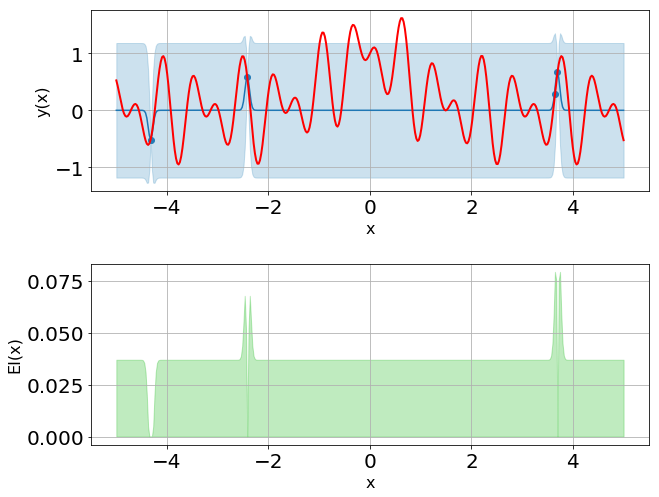

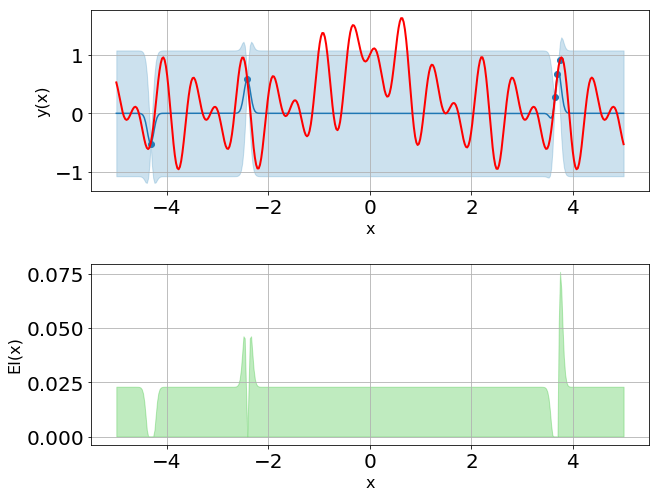

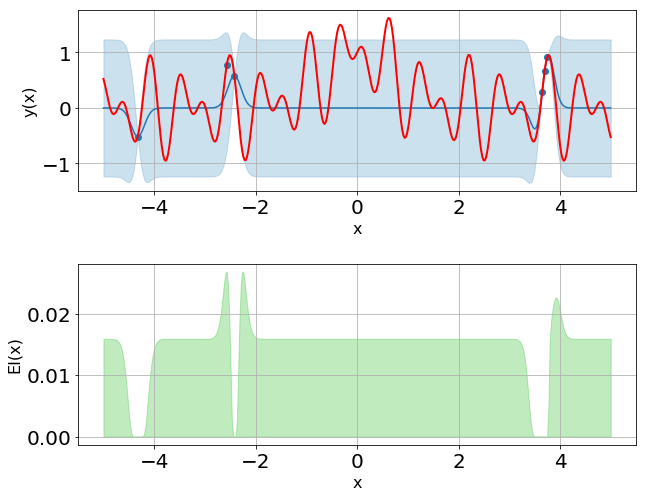

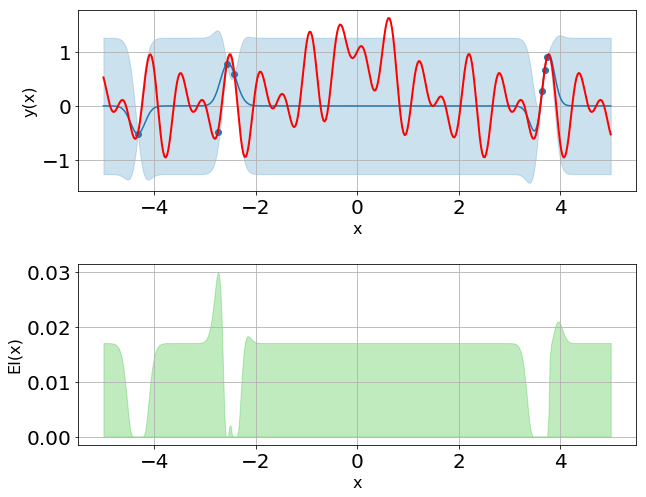

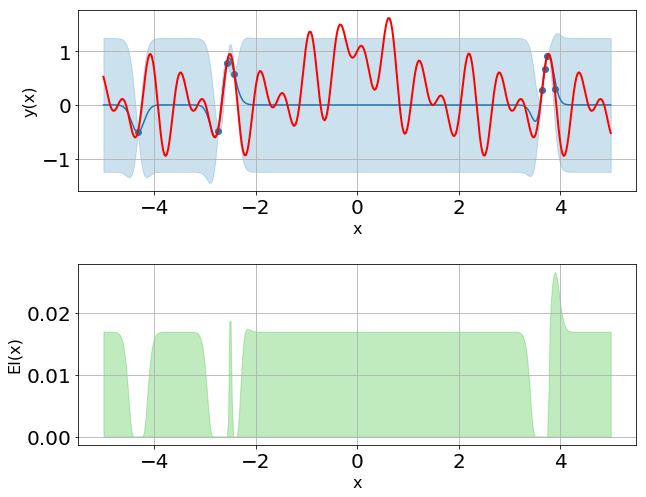

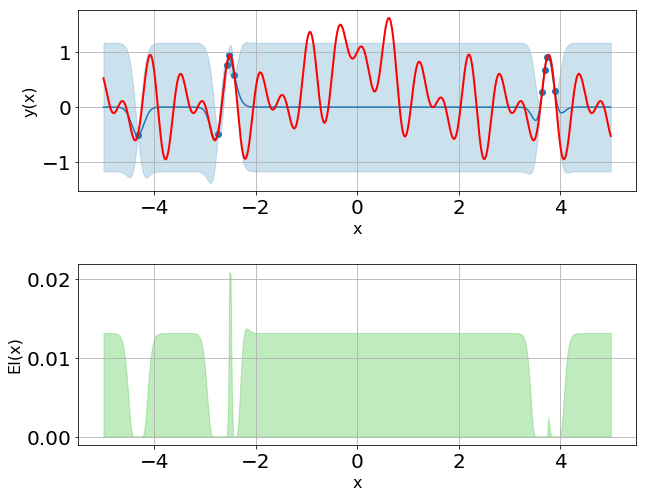

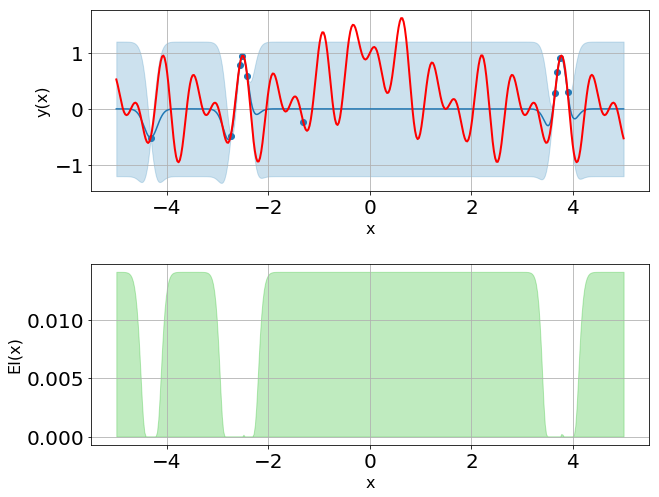

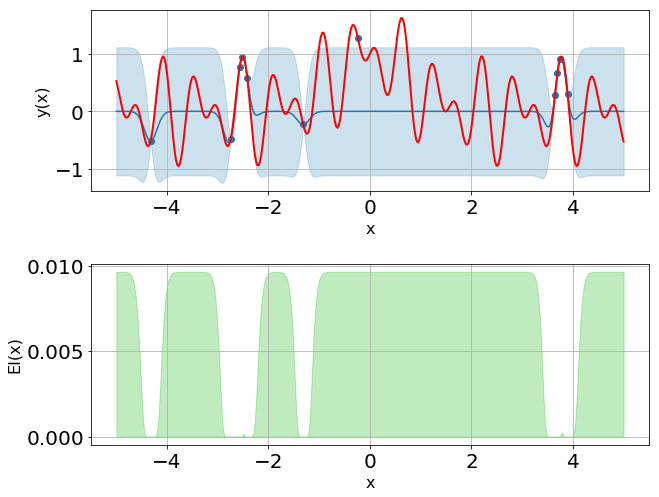

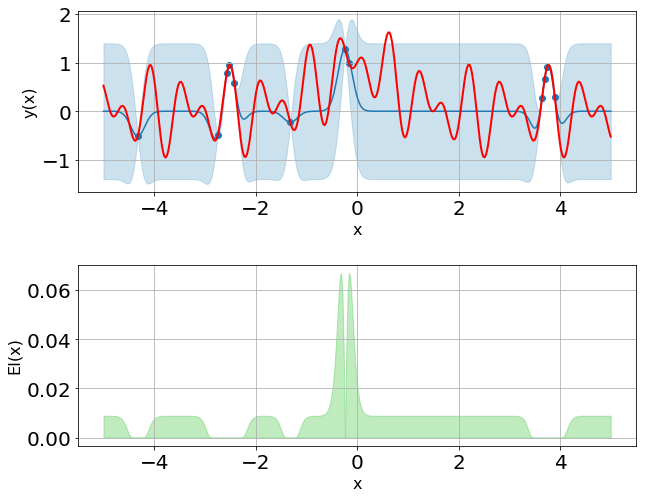

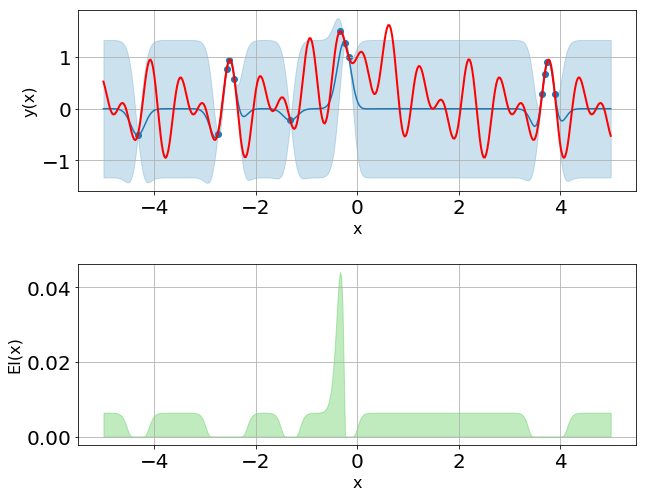

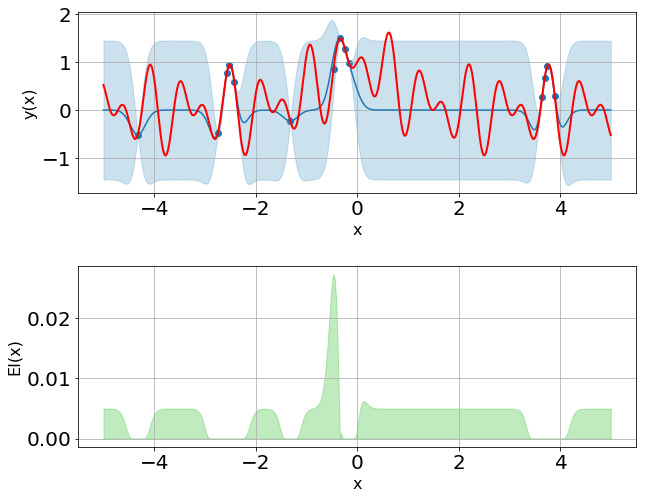

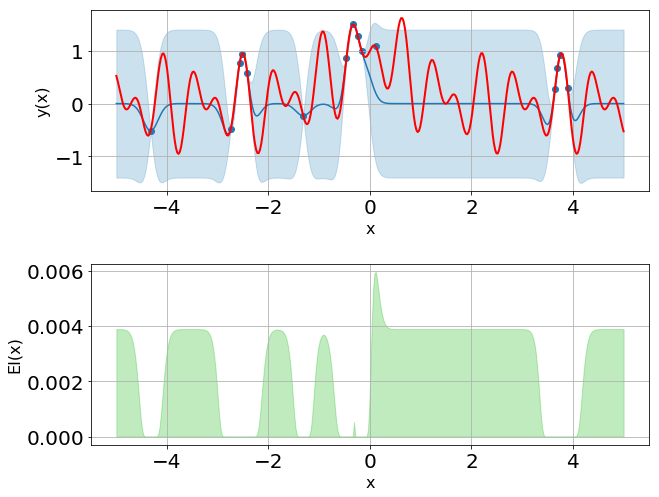

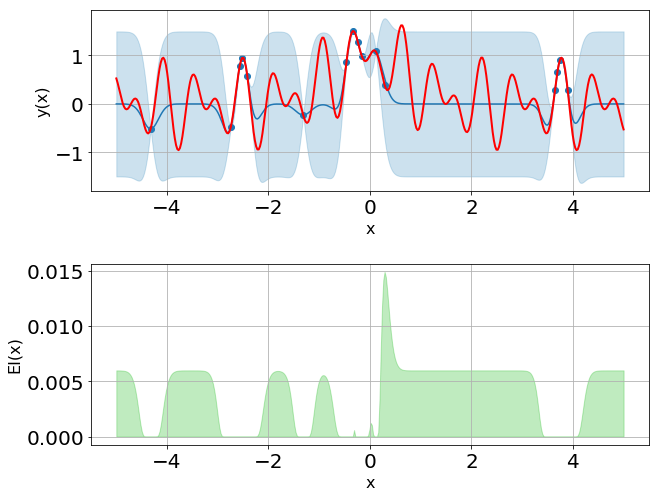

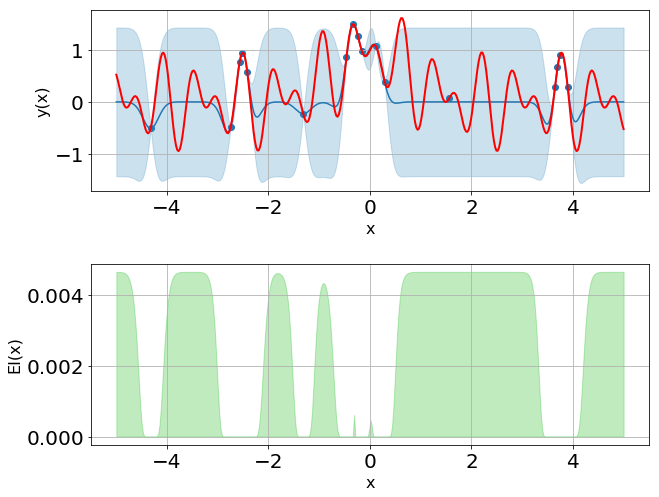

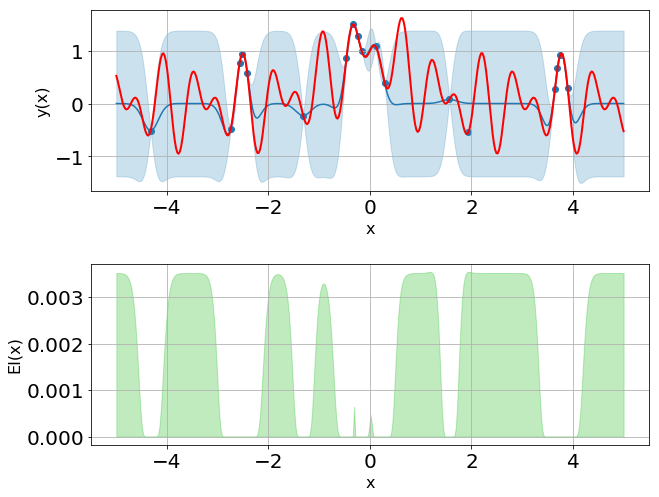

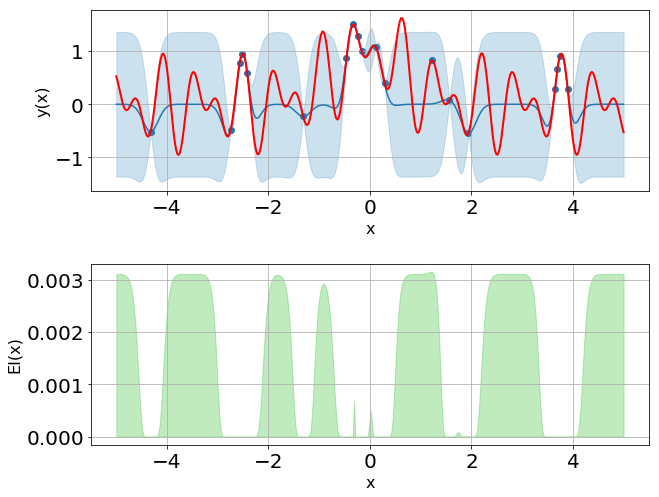

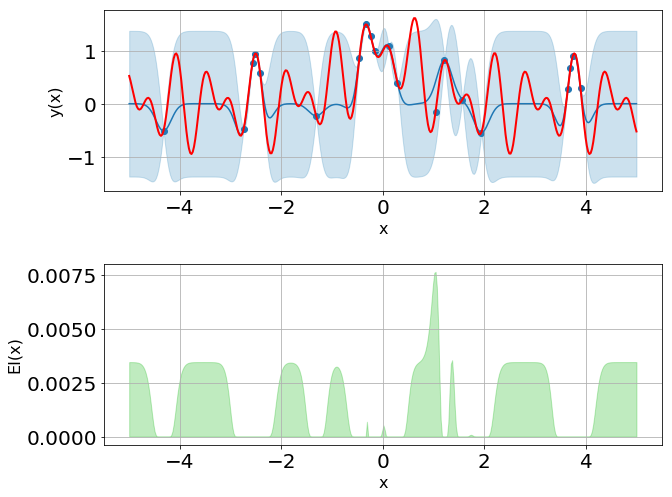

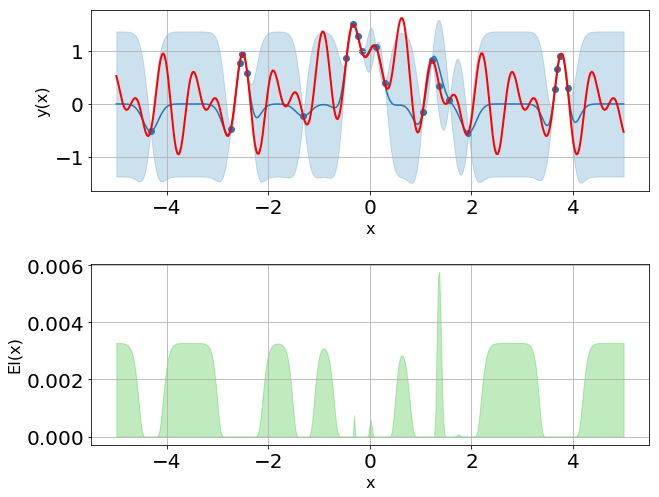

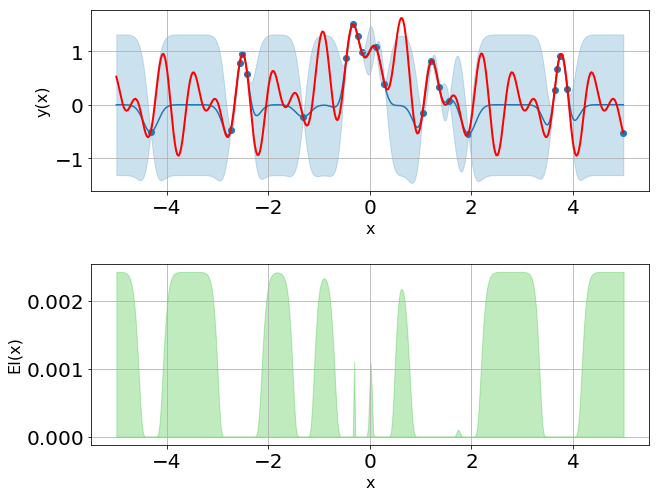

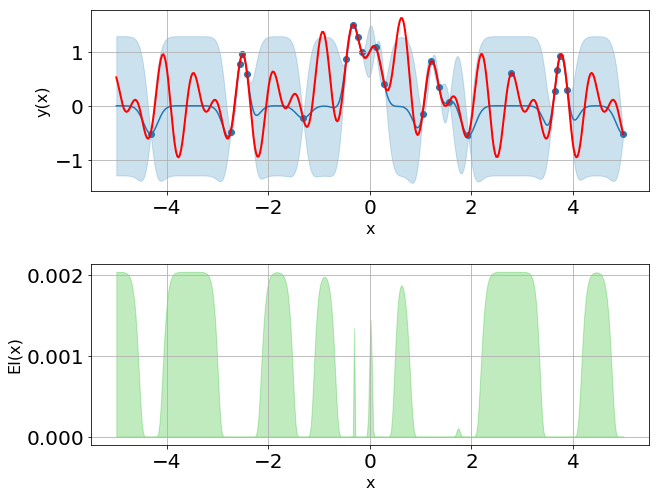

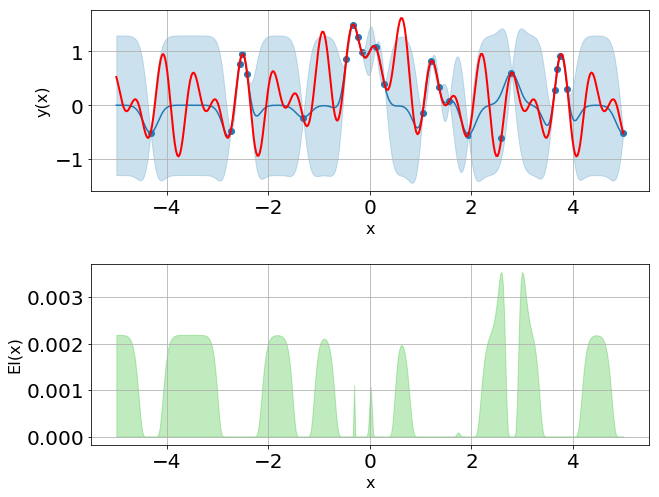

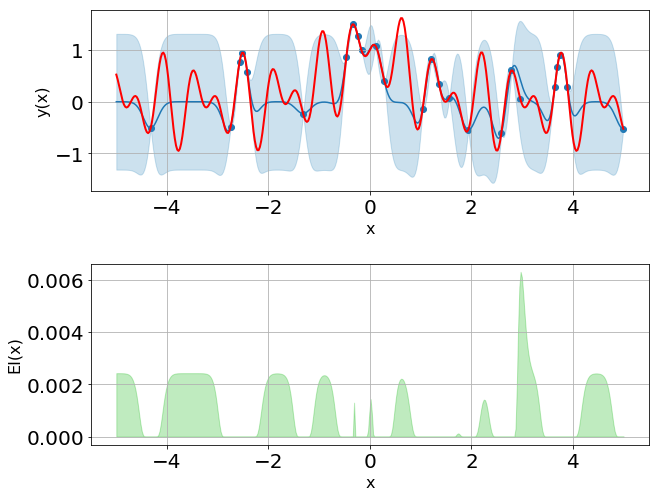

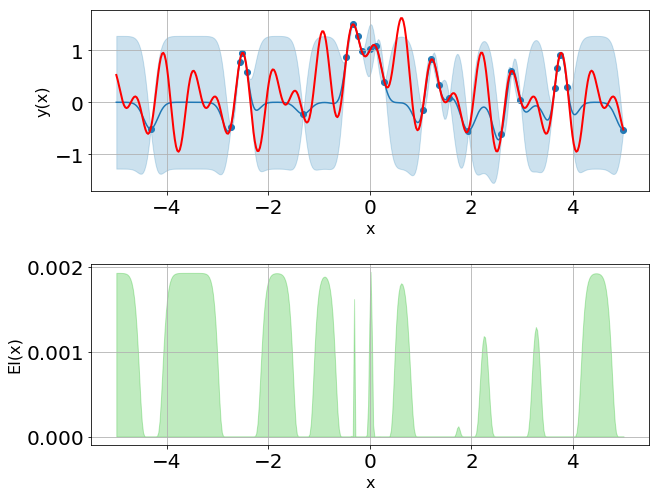

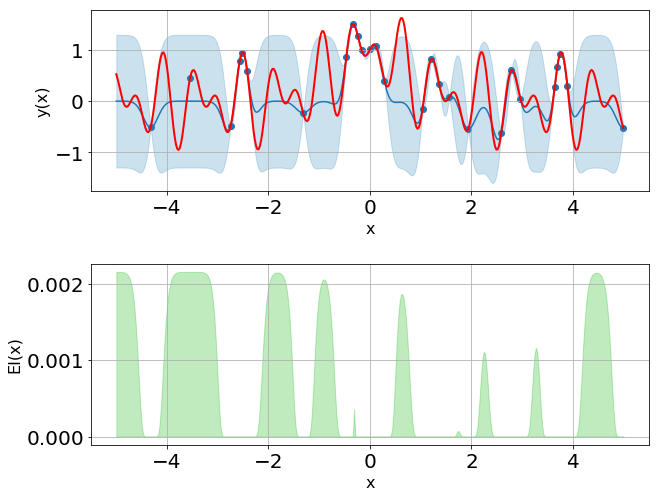

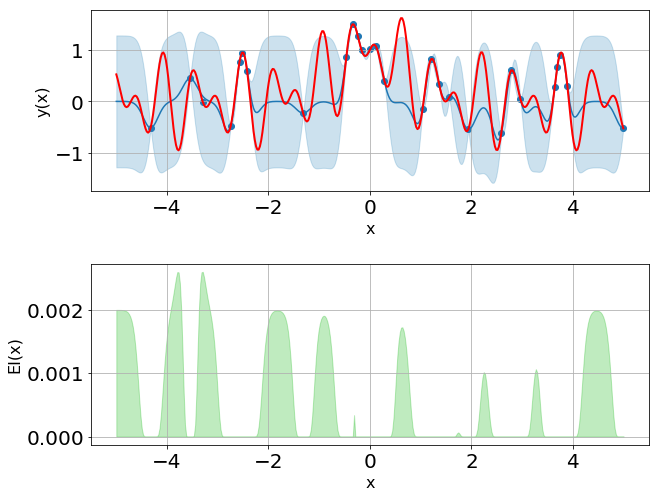

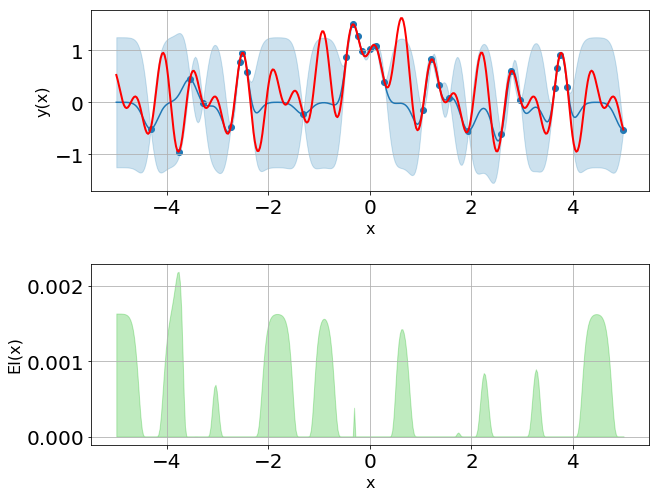

KeyboardInterrupt: 

In [327]:
# BayesOpt 1D
nT = 3
ii = np.random.permutation(P)
xT = x[ind[:nT]]; yT = y[ind[:nT]]; xTest = x[ind[nT:]]; yTest = ind[ind[nT:]];

ei_tol = 1e-9
exitflag = 0
kappa = 0.01

nruns = 10
max_its = 1e3
alpha = 0.01
beta = 1
normrule = 'component'
steprule = 'normal'
k = 1

Mu_hist = []
Cov_hist = []
EI_hist = []
theta_hist = []
xT_hist = []; yT_hist = []

while exitflag == 0:
    Daa = distmat_v2(xT,xT)
    theta = hypopt_wrap(nruns,max_its,alpha,beta,normrule,steprule,xT,yT,Daa,sigmaY)
    Mu,Cov,_,_,_,_,_,_ = gprfcn(x,xT,yT,theta,sigmaY)
    ei = expected_improvement(Mu,Cov,kappa)
    jj = np.argmax(ei); ei_max = ei[jj];
    x_next = x[jj,:]; y_next = y[jj];
    
    if flag_plot == 1:
        plot1Dgpr(x,y,xT,yT,x,Mu,Cov,ei)  
    else:
        print('Iteration-'+str(k)+'; EI = '+str(ei_max)+'; theta = '+str(theta)+'; x = '+str(x_next)+'; dx = '+str(x_next-xmax))

    xT = np.vstack((xT,x_next)); yT = np.vstack((yT,y_next))
    
    Mu_hist.append(Mu); Cov_hist.append(Cov); EI_hist.append(ei); theta_hist.append(theta); 
    xT_hist.append(xT[-1,:]); yT_hist.append(yT[-1,:]);
    
    

    k += 1
    if ei_max < ei_tol:
        exitflag = 1
    


### 2D Mixture Data###

In [4]:
# Load in data
mat = sp.io.loadmat('red3yellow3_4.15.19_processed.mat')

IMcc = mat['IMbase'];
Cc = mat['Cc']

p = 40;
X1 = IMcc[p,:];

N = IMcc.shape[0]
x = np.zeros((IMcc.shape[0],2))
y = np.zeros((IMcc.shape[0],1))
for i in range(IMcc.shape[0]):
    y[i] = -np.mean( (IMcc[i,:]-X1)**2 )
    x[i,:] = Cc[:,i]
ff = 1e5
x = x*ff
imax = np.argmax(y); ymax = y[imax]; imax = x[imax,:];

nT = N-1;
ind = np.random.permutation(IMcc.shape[0]); np.delete(ind,np.argwhere(ind==p))
xT = x[ind[:nT],:]; yT = y[ind[:nT]];
xTest = x[p,:]; yTest = y[p];

numpts = 70;
sx = np.unique(np.hstack((np.linspace(np.min(x[:,0]),np.max(x[:,0]),numpts),xT[:,0])))
sy = np.unique(np.hstack((np.linspace(np.min(x[:,1]),np.max(x[:,1]),numpts),xT[:,1])))

xp = np.zeros((len(sx)*len(sy),2))
ct = 0
for i in range(len(sx)):
    for j in range(len(sy)):
        xp[ct,:] = np.array([sx[i],sy[j]])
        ct += 1

        
sigmaY = 0.0
Daa = distmat_v2(xT,xT)

In [5]:
th0 = np.linspace(0.01,2,500)
M = np.zeros((len(th0),len(th0)))
for i in range(len(th0)):
    for j in range(len(th0)):
        M[i,j] = mlefcn(xT,yT,Daa,np.array([th0[i],th0[j]]),sigmaY)

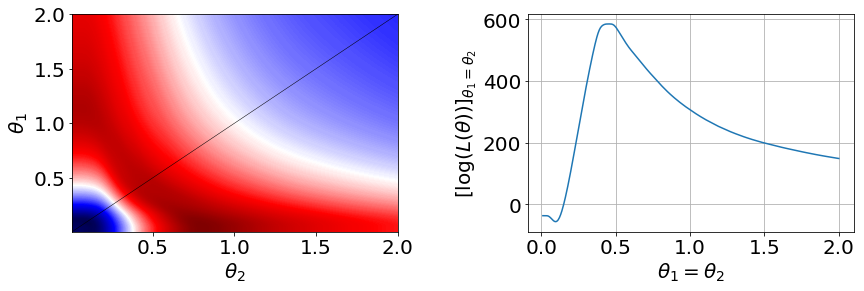

In [24]:
fig = plt.figure(figsize = (14,4))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(1,2,wspace=0.4) 
ax1 = plt.subplot(gs[0]);  ax2 = plt.subplot(gs[1]);

ax1.contourf(th0,th0,M,300,cmap='seismic')
ax1.plot(th0,th0,color=[0,0,0],linewidth=0.5)
ax1.set_xlabel(r'$\theta_2$')
ax1.set_ylabel(r'$\theta_1$')
ax2.plot(th0,np.diag(M))
ax2.set_ylabel(r'$[\log(L(\theta))]_{\theta_1=\theta_2}$')
ax2.set_xlabel(r'$\theta_1=\theta_2$')
ax2.grid(True)
#plt.xlim([0,0.2])
#plt.ylim([0,0.2])

In [516]:
Daa = distmat_v2(xT,xT)
nruns = 200
max_its = 500
alpha = 0.01
beta = 1
normrule = 'component'
steprule = 'normal'
#theta_hist,fval,flag = hypopt(nruns,max_its,alpha,beta,normrule,steprule,xT,yT,Daa,sigmaY)
theta = hypopt_wrap(nruns,max_its,alpha,beta,normrule,steprule,xT,yT,Daa,sigmaY)
theta

array([0.1036165, 0.0995048])

In [517]:
Mu,Cov,K,Ks,Kss,L,alpha,v = gprfcn(xp,xT,yT,theta,sigmaY)
ei = expected_improvement(Mu,Cov,0.01)
Mu_rs = np.reshape(Mu,(len(sy),len(sx)))
Var_rs = np.reshape(np.diag(Cov),(len(sy),len(sx)))
Sig_rs = np.sqrt(Var_rs)

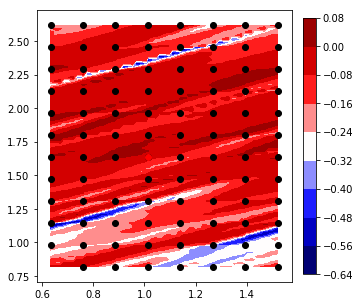

In [523]:
fig = plt.figure(figsize = (5,5))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0])
im = ax.contourf(sx,sy,Mu_rs,cmap='seismic')
ax.scatter(xT[:,0],xT[:,1],color=[0,0,0])
ax.scatter(xTest[0],xTest[1],color=[1,0,0])
plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)

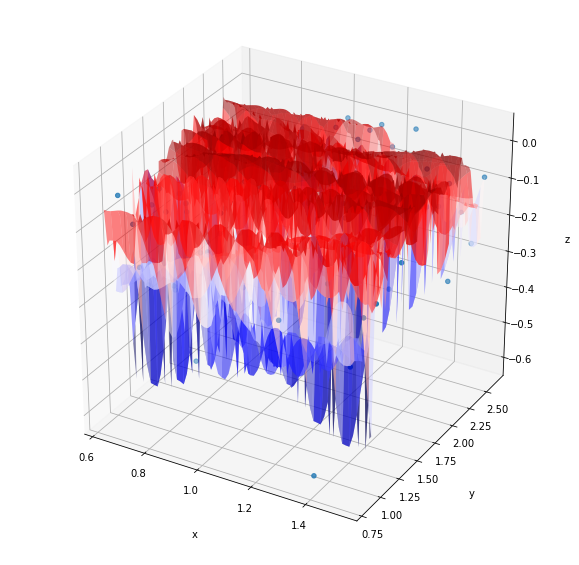

In [522]:
fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],projection='3d');
xplot,yplot = np.meshgrid(sx,sy)
im1 = ax.plot_surface(xplot,yplot,Mu_rs,alpha = 0.5,cmap='seismic')
#ax.plot_wireframe(xplot,yplot,Mu_rs+2*Sig_rs,alpha = 0.1,color = 'r')
#ax.plot_wireframe(xplot,yplot,Mu_rs-2*Sig_rs,alpha = 0.1,color = 'r')
ax.set_xlabel('x',labelpad=20)
ax.set_ylabel('y',labelpad=20)
ax.set_zlabel('z',labelpad=20)
ax = fig.gca(projection='3d')
ax.scatter(x[:,0],x[:,1],y)
#ax.view_init(0,0)

In [407]:
theta

array([-0.09519949,  0.10205143])